In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, ColumnDataSource

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

# Yelp Reviews and Restaurants

## **Motivation**
We are working with two datasets from Yelp. One containing a subset of businesses in USA and Canada and one containing reviews of these businesses. We chose this dataset as we thought it would be fun and interesting to analyse review trends both time-wise and geographically. Furthermore, the datasets is larget enough and contain enough information to hopefully gain alot of fun insights. As the dataset contains only a subset of the cities on yelp we chose to work specifically on the Philidelphia part of the dataset as this was the largest city present.

Yelp reviews are important because they help people decide where to eat. A 2022 article from Propel [^1] explains that Yelp has a big influence on small businesses in Philadelphia, and that star ratings are one of the first things new customers notice.

Another article from Yelp for Business [^2] shows that 96% of people on Yelp compare different places before deciding where to go. This supports our goal of helping readers explore their options and make a good choice using Yelp data. Additionally, the article tells that many users take action quickly, often reaching out to a business the within a day of researching its reviews. This shows that reviews aren’t just opinions but they actually affect real decisions people make right away. 

A Medium article by an economist [^3] also points out that Yelp reviews reflect more than just food quality. They can show things like the customer’s expectations, their mood, or even the time they visited. 

In the end, we want our project to help readers see useful patterns in Yelp reviews and guide them toward the best places, times, and experiences in Philadelphia.



## **Basic Stats**
In this section we cover the two datasets and out choices in data preparation and preprocessing as well as some basic stats of the data.

### *Data: Businesses*
The full business dataset contains ~150.000 businesses and for each of these it has:
- Name
- Business ID
- Location 
- Average rating from 1-5
- Number of reviews
- Categories (Hotel, Restaurant, etc.)
- Various attributes (Such as parking or payment options)
- Opening hours

Firstly we want to filter the business data to contain only those in Philadelphia:

In [26]:
# Load and filter the business dataset
df_business = pd.read_json('../data/yelp_academic_dataset_business.json', lines=True)
df_business = df_business[df_business['city'] == 'Philadelphia']
print(f"Number of businesses in Philadelphia: {len(df_business)}")
print("Sample data from the business dataset:")
# Display the first row of the filtered dataset
df_business.head(1)

FileNotFoundError: File ../data/yelp_academic_dataset_business.json does not exist

We then want to find those that are labeled as restaurants:

In [ ]:
restaurant_ids = set()
for _, b in df_business.iterrows():
    if b['categories'] and 'Restaurants' in b['categories']:
        restaurant_ids.add(b['business_id'])
print(f"Number of restaurants in Philadelphia: {len(restaurant_ids)}")


Number of restaurants in Philadelphia: 5852


We see that we have data on 5852 restaurants in Philadelphia.

### *Data: Reviews*
The full review dataset contains ~7.000.000 reviews and for each of these it has:
- Review ID
- User ID
- Business ID
- Rating
- Other users' opinion of the review
- Textual review
- Date and time of day

Firstly, we want to look solely on the reviews for restaurants which we have data on:

In [ ]:
df_reviews = pd.read_json('../data/philadelphia_restaurant_reviews.json', lines=True)
# Filter reviews to include only those for restaurants in Philadelphia
df_reviews = df_reviews[df_reviews['business_id'].isin(restaurant_ids)]
print(f"Number of reviews for restaurants in Philadelphia: {len(df_reviews)}")
print("Sample data from the reviews dataset:")
# Display the first row of the filtered dataset
df_reviews.head(1)

Number of reviews for restaurants in Philadelphia: 687289
Sample data from the reviews dataset:


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03


We see that we have just under 700.000 reviews of restaurants in Philadelphia

## **Data Analysis**



## *Distribution of Ratings*
Initially we want to look at the distribution of ratings for the restaurants in Philadelphia. We wish to see if reviewers generally give high or low ratings. To do this we will plot the distribution of ratings for all restuarant reviews in the dataset. This can then be compared to rating of each restaurant to see if there is a correlation between the two. 

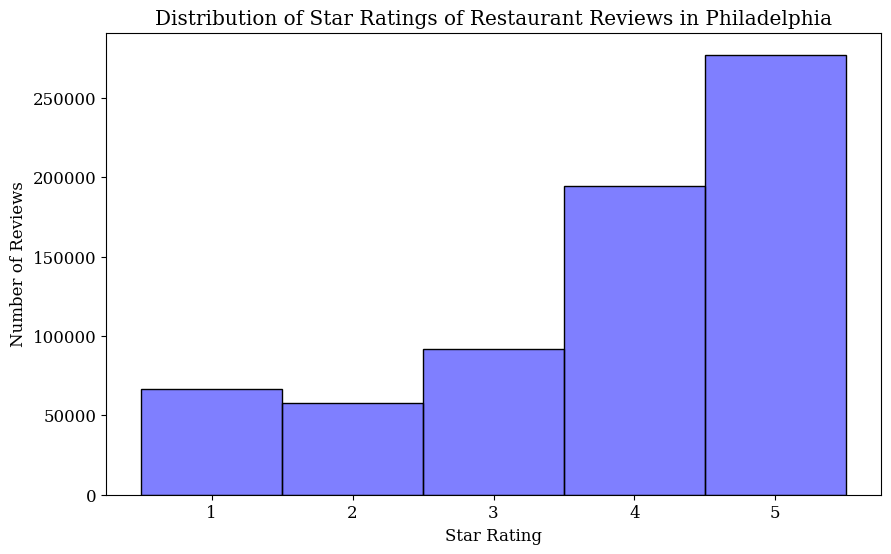

In [30]:
df = pd.read_json('../../philadelphia_restaurant_reviews.json', lines=True)
df_businesses = pd.read_json('../../yelp_academic_dataset_business.json', lines=True)
df_businesses = df_businesses[df_businesses['city'] == 'Philadelphia']
# Filter the businesses to only include restaurants
df_businesses = df_businesses[df_businesses['categories'].str.contains('Restaurants', na=False)]
# Histogram of the number of reviews per star rating
plt.figure(figsize=(10, 6))
sns.histplot(df['stars'], bins=5, color='blue', alpha=0.5, label='Star Rating', discrete=True)
plt.xticks([1, 2, 3, 4, 5])  # Ensure ticks are at the center of each bar
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Star Ratings of Restaurant Reviews in Philadelphia')
plt.show()


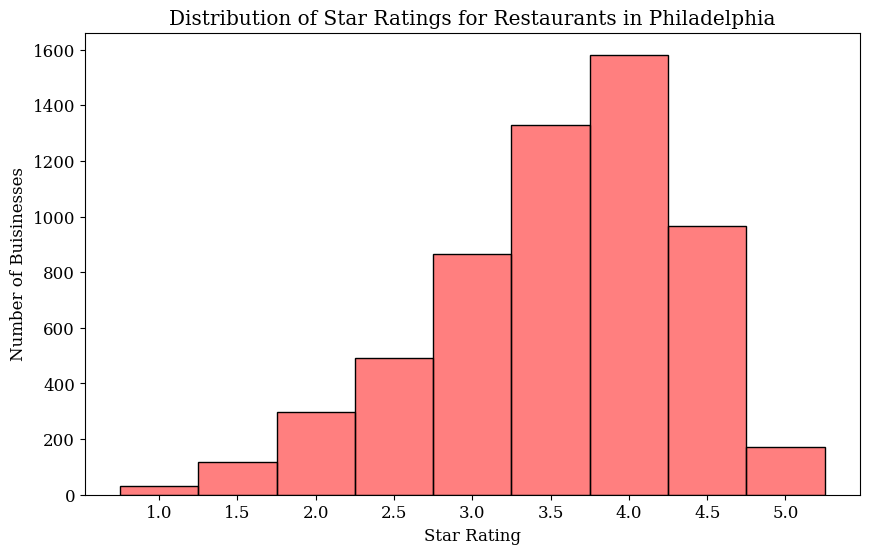

In [31]:
bin_width = 0.5
min_star = df_businesses['stars'].min()
max_star = df_businesses['stars'].max()
bin_edges = np.arange(min_star - bin_width/2, max_star + bin_width, bin_width)

plt.figure(figsize=(10, 6))
sns.histplot(df_businesses['stars'], bins=bin_edges, color='red', alpha=0.5)

# Set xticks at each star rating level
plt.xticks(np.arange(1.0, 5.1, 0.5))  # Ticks from 1.0 to 5.0 by 0.5 steps
plt.xlabel('Star Rating')
plt.ylabel('Number of Buisinesses')
plt.title('Distribution of Star Ratings for Restaurants in Philadelphia')
plt.show()

From the '*Distribution of Star Ratings of Restaurant Reviews in Philadelphia*'-plot we can see that the distribution is skewed to the right. This means that most reviews are rated 4 or 5 stars. This indicates that most reviewers are happy with the restaurants they visit in Philadelphia. This trend can be seen in the '*Distribution of Star Ratings of Restaurants in Philadelphia*'-plot as well. Here we again see skewed distribution to the right, indicating that most restaurants have a high rating. 

The dataset contains numerous restaurants of many different categories that we wish to explore further. We will do this by looking at the distribution of ratings for each category. The categories analyzed will be the 25 most common ones in the buisness dataset as well as '*cheesesteaks*' as this is a very popular dish in Philadelphia.

In [33]:
# split the categories into separate columns
df_businesses['categories'] = df_businesses['categories'].str.split(',')
df_businesses = df_businesses.explode('categories')
df_businesses['categories'] = df_businesses['categories'].str.strip()

# remove categories that appears less than 200 times
category_counts = df_businesses['categories'].value_counts()
categories_to_remove = category_counts[(category_counts < 200)].index
# remove cheesesteaks from the categories to remove
categories_to_remove = categories_to_remove[~categories_to_remove.str.contains('Cheesesteaks', na=False)]
df_businesses = df_businesses[~df_businesses['categories'].isin(categories_to_remove)]

# remove 'restaurants' and 'food' from the categories
df_businesses = df_businesses[~df_businesses['categories'].str.contains('Restaurants', na=False)]
df_businesses = df_businesses[~df_businesses['categories'].str.contains('Food', na=False)]


# select the top 25 categories
top_categories = df_businesses['categories'].value_counts().nlargest(25).index

# filter the dataframe to only include the top 25 categories
df_businesses = df_businesses[df_businesses['categories'].isin(top_categories)]
df_group = df_businesses.groupby(['categories', 'stars']).size().reset_index(name='counts')
category_counts = df_businesses.value_counts('categories')
for index, row in df_group.iterrows():
    category = row['categories']
    df_group.at[index, 'normalized_counts'] = row['counts']/category_counts[category]
df_group = df_group.pivot(index='stars', columns='categories', values='normalized_counts')
source = ColumnDataSource(df_group)

# stars to string
stars = [str(star) for star in np.sort(df_businesses['stars'].unique())]
p = figure(x_axis_label = 'Stars', y_axis_label = 'Normalized Count', width=800, height=700)
p.title.text = 'Distribution of Star Ratings for various restaurant categories in Philadelphia'


bar ={} # to store vbars
categories = df_group.columns.tolist()

HighContrast27 = [
    "#1f77b4",  # Blue  
    "#ff7f0e",  # Orange  
    "#2ca02c",  # Green  
    "#d62728",  # Red  
    "#9467bd",  # Purple  
    "#8c564b",  # Brown  
    "#e377c2",  # Pink  
    "#7f7f7f",  # Gray  
    "#bcbd22",  # Olive  
    "#17becf",  # Teal  
    "#393b79",  # Dark Blue
    "#637939",  # Army Green
    "#8c6d31",  # Dark Tan
    "#843c39",  # Burgundy
    "#7b4173",  # Plum
    "#3182bd",  # Sky Blue
    "#f33e52",  # Bright Red
    "#31a354",  # Emerald Green
    "#756bb1",  # Violet
    "#636363",  # Charcoal Gray
    "#fdae6b",  # Light Orange
    "#a55194",  # Magenta
    "#9ecae1",  # Light Blue
    "#e7ba52",  # Mustard
    "#c7c7c7",  # Light Gray
    "#6baed6",  # Soft Blue
    "#fd8d3c",  # Orange Coral
]

for indx,i in enumerate(categories):
    bar[i] = p.vbar(x='stars',  top=i, source= source, 
                    ### we will create a vbar for each focuscrime
                    legend_label=i,  muted_alpha=0, alpha = 0.7, width = 0.5, color=HighContrast27[indx], muted = False if indx==6 or indx==16 else True) 
    

# p.select(dict(type='vbar'))[16].visible = True

p.add_layout(p.legend[0], 'left')
p.legend.click_policy="mute"
output_notebook()
show(p) 

Loading BokehJS ...

From the '*Distribution of Star Ratings of Restaurant Reviews in Philadelphia by Category*'-plot we can see that the distribution of ratings can vary quite a bit between different categories. For example, the '*Burgers*' category is more evenly distributed than, for example, the '*Japanese*' category. 

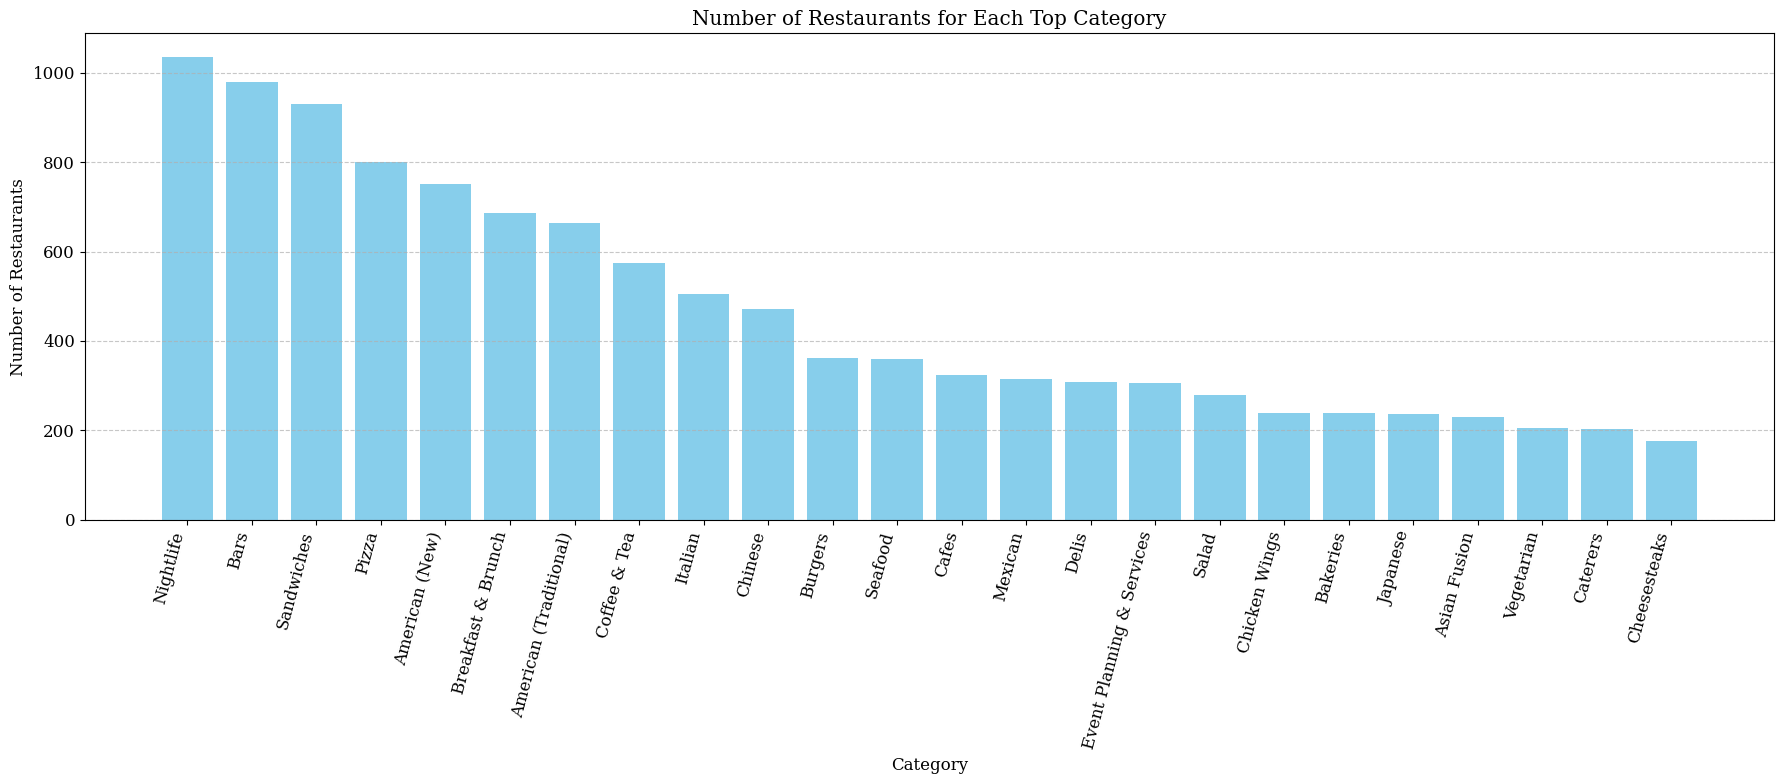

In [ ]:
category_counts = df_businesses['categories'].value_counts()
plt.figure(figsize=(18, 8))
plt.bar(category_counts.index, category_counts.values, color='skyblue')
plt.xticks(rotation=75, ha='right')
plt.xlabel("Category")
plt.ylabel("Number of Restaurants")
plt.title("Number of Restaurants for Each Top Category")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

By looking at the number of restaurants in each category, we get an idea of the popularity of each category in Philadelphia. It can be seen that the most popular categories are '*Nightlife*' and '*Bars*' folowed by '*Sandwiches*' and '*Pizza*'. 

## *Time Analysis*
In this part of the analysis, we look at restaurant reviews from Philadelphia to find out how time of day affects reviews.

We want to answer a few questions:

- When during the day do people leave the most reviews?

- Does the time of review change how good or bad the review is?

- Do some businesses get different kinds of reviews depending on the time? 

To find out, we made different plots to show the trends and patterns in the data.

To properly interpret these results, it's important to keep two things in mind:

- People don’t always write reviews while they’re at the restaurant.
- Reviews can be posted outside of the business’s opening hours, sometimes long after the visit took place.

Because of this, we should be cautious about drawing strong conclusions based purely on the review timestamps. They may not fully reflect the actual time of the dining experience.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Knowing that the JSON file is structured with each line as a separate JSON object
philly_reviews_df = pd.read_json('../data/philadelphia_restaurant_reviews.json', lines=True)

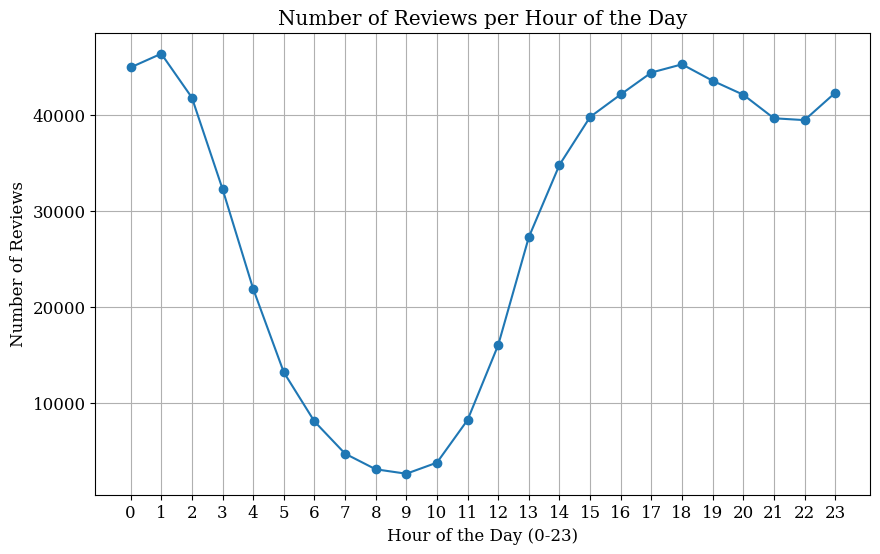

In [ ]:
# Extract the hour from the 'date' column
philly_reviews_df['hour'] = philly_reviews_df['date'].dt.hour

# Group by hour and count the number of reviews for each hour
reviews_per_hour = philly_reviews_df.groupby('hour').size()

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12       
   
plt.figure(figsize=(10,6))
reviews_per_hour.plot(kind='line', marker='o')

plt.title('Number of Reviews per Hour of the Day')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.xticks(range(0,24))
plt.show()

To begin, we created a line chart that shows how the number of reviews changes depending on the hour of the day.
From the plot, it's clear that most reviews are written between 4 PM and 2 AM. This makes sense, since restaurants are usually busiest during dinnertime and late at night, when more people are out eating or grabbing late-night food and more customers often means more reviews. 



### *Line chart of different star rating distribution depending on the time of day*
We wanted to see when people give different star ratings during the day. To do this, we made one line chart for each rating (from 1 to 5) showing the hours when reviews were written. 

For this plot, we used min-max normalization so that each rating is scaled between 0 and 1. The focus is on when people leave reviews, not how many. With normalization, we can better compare the timing patterns for all ratings, even the rare ones like 1-star.

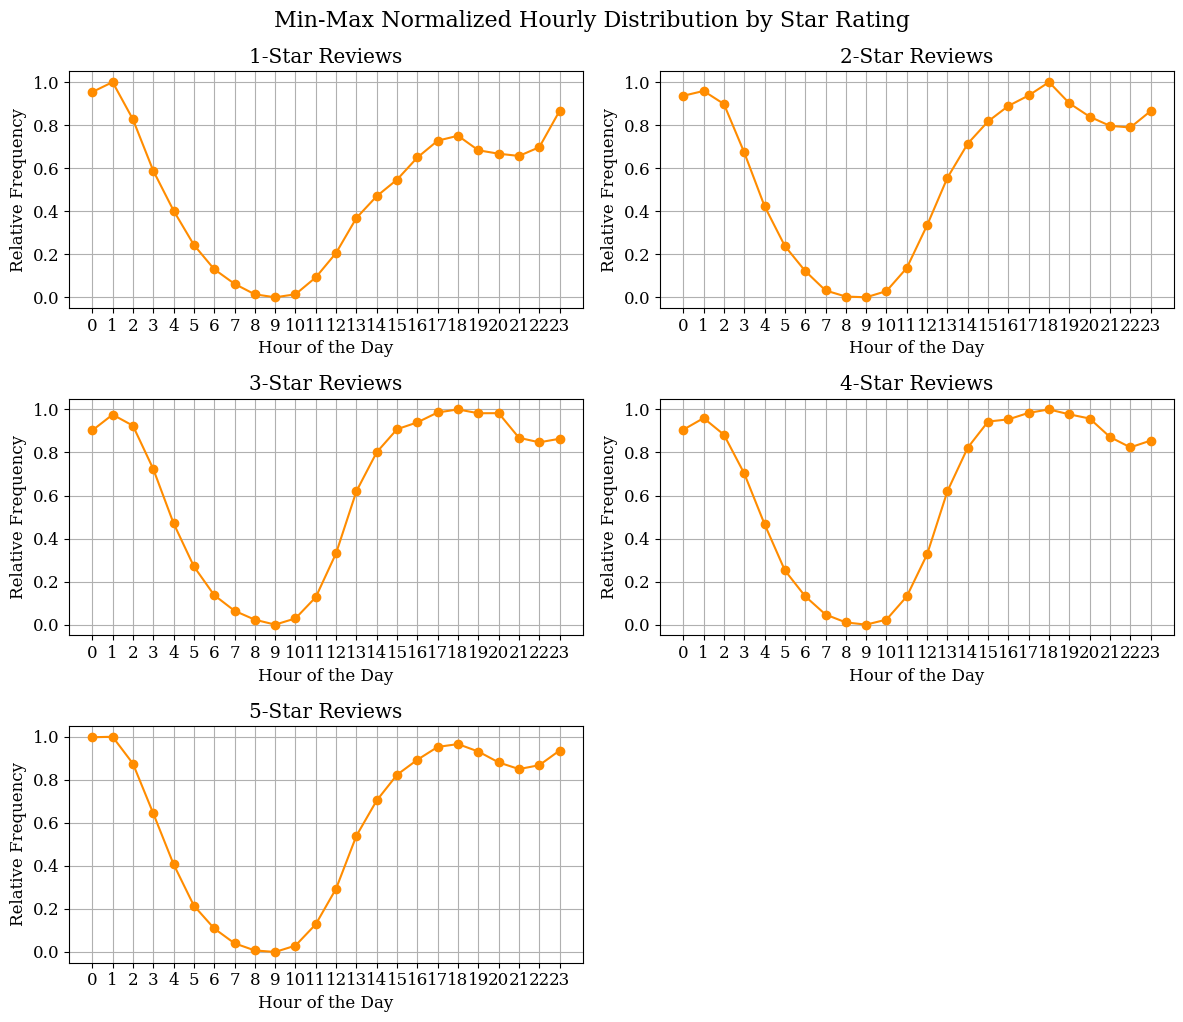

In [ ]:
import matplotlib.pyplot as plt

# Group by star and hour
grouped = philly_reviews_df.groupby(['stars', 'hour']).size().unstack(fill_value=0)
grouped = grouped.loc[grouped.index.intersection([1, 2, 3, 4, 5])]

# Min-max normalization
minmax_normalized = (grouped - grouped.min(axis=1).values[:, None]) / \
                    (grouped.max(axis=1) - grouped.min(axis=1)).values[:, None]
minmax_normalized = minmax_normalized.fillna(0)

# Set font style
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

# Setup subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot each star rating
for i, (star, row) in enumerate(minmax_normalized.iterrows()):
    ax = axes[i]
    row.plot(kind='line', marker='o', ax=ax, color='darkorange')
    ax.set_title(f"{int(star)}-Star Reviews")
    ax.set_xlabel("Hour of the Day")
    ax.set_ylabel("Relative Frequency")
    ax.set_xticks(range(0, 24))
    ax.grid(True)

fig.delaxes(axes[-1])

# Layout and title
plt.tight_layout()
plt.suptitle("Min-Max Normalized Hourly Distribution by Star Rating", fontsize=16, y=1.02)
plt.show()


From the charts, we can see that most reviews are written in the evening and late at night, while mornings have the fewest reviews across all star ratings.

### *Interactive chart of ratings depending on the time of day*
Secondly, we wanted to explore whether the star ratings people give change depending on the time of day.
To investigate this, we created an interactive Bokeh chart that allows users to toggle between different 3-hour time blocks and see how the distribution of star ratings changes throughout the day.

In [ ]:
import pandas as pd
from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import ColumnDataSource, FactorRange

output_notebook()

HighContrast10 = [
    "#1f77b4",  # Blue  
    "#ff7f0e",  # Orange  
    "#2ca02c",  # Green  
    "#d62728",  # Red  
    "#9467bd",  # Purple  
    "#8c564b",  # Brown  
    "#e377c2",  # Pink  
    "#7f7f7f",  # Gray  
    "#bcbd22",  # Olive  
    "#17becf"   # Teal  
]

# Prepare data
philly_reviews_df['date'] = pd.to_datetime(philly_reviews_df['date'])
philly_reviews_df['hour'] = philly_reviews_df['date'].dt.hour

# Create 3-hour time blocks
def map_three_hour_block(hour):
    start = (hour // 3) * 3
    end = start + 2
    return f"{start:02d}-{end:02d}"

philly_reviews_df['three_hour_block'] = philly_reviews_df['hour'].apply(map_three_hour_block)

# Count reviews per (star, time block)
grouped = philly_reviews_df.groupby(['stars', 'three_hour_block']).size().unstack(fill_value=0)

# Make sure columns are sorted by time
time_blocks = sorted(grouped.columns)
grouped = grouped[time_blocks]

for star in range(1, 6):
    if star not in grouped.index:
        grouped.loc[star] = [0] * len(time_blocks)

grouped = grouped.sort_index()
grouped.index = grouped.index.map(str)
stars = grouped.index.tolist()

grouped.reset_index(inplace=True)
grouped.rename(columns={'stars': 'stars'}, inplace=True)
source = ColumnDataSource(grouped)

p = figure(x_range=FactorRange(*stars),
           height=500, width=900,
           title="Review Counts per Star Rating across 3-Hour Blocks",
           toolbar_location="above", tools="pan,wheel_zoom,reset,save")

colors = HighContrast10

for i, block in enumerate(time_blocks):
    p.vbar(x='stars',
           top=block,
           source=source,
           width=0.2,
           color=colors[i % len(colors)],
           legend_label=block,
           muted_alpha=0.1,
           muted=True,
           alpha=0.7)

p.xaxis.axis_label = "Star Rating"
p.yaxis.axis_label = "Number of Reviews"
p.xaxis.major_label_orientation = 1.0
p.x_range.range_padding = 0
p.y_range.start = 0
p.title.text_font_size = "14pt"
p.legend.location = "top_left"
p.legend.click_policy = "mute"
p.add_layout(p.legend[0], 'left')

show(p)



Loading BokehJS ...

From this chart, users can easily toggle between different time slots to see how star ratings are distributed throughout the day.
However, the overall pattern looks very similar across all time blocks:

- 1-star reviews are more common than 2-star reviews
- 5 stars is the most frequently given rating in all time slots
- 4-star reviews are more common than 3 stars, but less common than 5 stars
- 3-star reviews appear more often than both 1- and 2-star reviews

### *Time analysis of three specific businesses*
For the next step, we wanted to dig deeper into individual businesses to see how star ratings vary throughout the day.
To find businesses worth studying, we first filtered for businesses with at least 50 reviews to ensure the data was reliable.
Then, we calculated the standard deviation of star ratings for each business and selected those with the highest variation.
Businesses with a wide range of different reviews are especially interesting to investigate, as they might show stronger time-based trends. As an example, this can be used for Yelp users to determine at what time they should go to the restaurant.

['97SR7RQPL02t5J41UcZ4SQ', 'jPG_BuIKf0KBCFY6u00h-A', 'fT0lXvUz41XaZbgtSMqTKg']
Top 3 businesses with highest variation and their review counts:
- Pat's Pizzeria: 51 reviews
- Love Park Pizza and Chicken: 55 reviews
- Mangiamo 444: 55 reviews


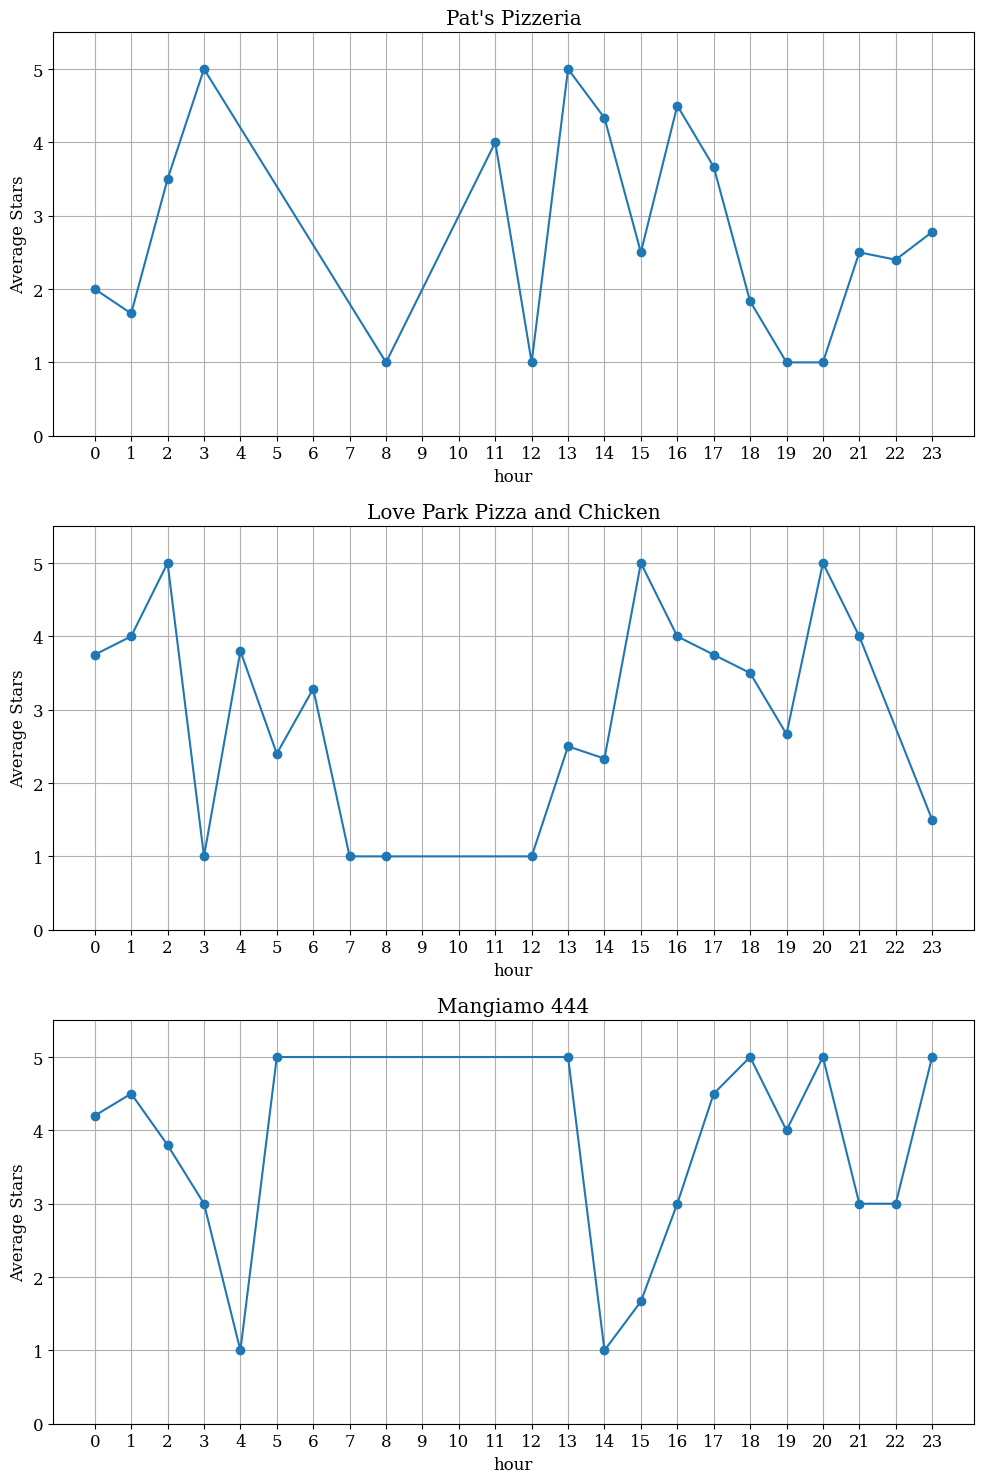

In [ ]:
business_df = pd.read_json('../data/yelp_academic_dataset_business.json', lines=True)

# Count number of reviews per business
review_counts = philly_reviews_df.groupby('business_id').size()

# Keep only businesses with at least 50 reviews
businesses_with_enough_reviews = review_counts[review_counts >= 50].index.tolist()

# Group reviews by business and hour, and calculate mean stars
business_hour_avg = philly_reviews_df.groupby(['business_id', 'hour'])['stars'].mean().reset_index()

# Calculate std for each business
business_variability = business_hour_avg.groupby('business_id')['stars'].std()

# Keep only businesses with enough reviews
business_variability = business_variability[business_variability.index.isin(businesses_with_enough_reviews)]

# Sort and pick top 3 businesses
top_variable_business_ids = business_variability.sort_values(ascending=False).head(3).index.tolist()

print(top_variable_business_ids)
print("Top 3 businesses with highest variation and their review counts:")
for business_id in top_variable_business_ids:
    count = review_counts[business_id]
    business_info = business_df[business_df['business_id'] == business_id]
    business_name = business_info['name'].values[0]
    print(f"- {business_name}: {count} reviews")

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(10, 15))

for i, business_id in enumerate(top_variable_business_ids, 1):
    business_info = business_df[business_df['business_id'] == business_id]
    business_name = business_info['name'].values[0]

    reviews = philly_reviews_df[philly_reviews_df['business_id'] == business_id].copy()

    reviews['date'] = pd.to_datetime(reviews['date'])
    reviews['hour'] = reviews['date'].dt.hour

    stars_per_hour = reviews.groupby('hour')['stars'].mean()

    plt.subplot(3, 1, i)
    stars_per_hour.plot(kind='line', marker='o')
    plt.title(f'{business_name}')
    plt.ylim(0, 5.5)
    plt.grid(True)
    plt.xticks(range(0, 24))
    plt.ylabel('Average Stars')

plt.tight_layout()
plt.show()


### *Pat's Pizzeria*
Opening hours: 11:00 - 23:30

Pat’s Pizzeria shows a lot of variation during the day.
- Some early morning and midday reviews are as low as 1 star, while others reach 5 stars.
- The pattern is inconsistent, which could point to changing customer experiences depending on time. This could be caused by differences in staff or the state of the customers themselves (e.g. diner guests vs. lunch guests).

Based on the plot, a user might prefer to visit Pat’s Pizzeria either at lunchtime or late in the evening, as those are the times when reviews tend to be more positive.

### *Love Park Pizza and Chicken*
Opening hours: 10:00 - 3:30 

This business also shows significant variation in review scores throughout the day:
- Some time slots (such as 2 AM, 3 PM, and 8 PM) reach 5-star ratings, while others drop to just 1 or 2 stars.
- The ratings change sharply from hour to hour, which may reflect inconsistent service quality or differences in the type of customers at various times (e.g., post-party visitors vs. lunch diners).

Based on the trend, the best time to visit seems to be at the end of peak periods, like after lunch, dinner, or late-night hours.
In contrast, this business appears to be a poor choice for breakfast, as early reviews tend to be lower.

### *Mangiamo 444*
Opening hours: 16:00 - 21:30

This business has a very sharp pattern:

- During opening hours, the restaurants receive 3 stars or more. 
- But during night and afternoon hours, ratings drop as low as 1 star.

Interestingly, the lowest ratings are typically posted outside of business hours.
This could suggest that customers had time to reflect on their experience before writing a more critical review.
However, there are also a few 5-star reviews posted in the morning, indicating that not all delayed reviews are negative.

### *Conclusion for the time analysis of three businesses*
All three businesses show that review ratings can vary significantly throughout the day, and some may have consistent weak spots (e.g. breakfast time for the first two businesses).
This kind of hour-by-hour analysis could be useful for businesses to identify problem times and improve consistency.

## **Genre**
Figure 7 in Segal and Heer shows a lot of different tools for good visualization in data stories. Below is described how we have used the different tools in our data story project.   
### **Visual Narrative**
- **Visual Structuring:** We used the *Consistent Visual Platform* method, where same style and layout used in all plots. Additionally, we used the *Checklist" Progress Tracker*. The notebook follows a step-by-step structure, starting with an introduction and moving through each part of the analysis. This helps the reader understand where they are in the story.
- **Highlighting:** We have used the *Feature Distinction*, as we used different colors to show different time blocks in our Bokeh plots. This made it easier to compare trends across the day and spot differences.
- **Transition Guidance:** In the interactive plots, such as the Bokeh chart and the heatmap video, we did *Animated Transitions*. Time blocks appear and disappear when clicked in the Bokeh chart and the user are able to pause the heatmap video. This helps the viewer stay focused when the animations change. 
### **Narrative Structure**
- **Ordering:** We used a linear order in our data story. That means the reader goes through the story step by step, starting with an introduction and moving through the analysis.
We chose this because it's easy to follow and helps make sure the reader doesn’t miss any important points.
- **Interactivity:** We used *filtering and selection* in the Bokeh plots, where the user can click the legend to show or hide different time blocks and focus on specific parts of the data. In the heatmap video, we used *very limited interactivity*, where the user just watches the trend over time without needing to do anything except zoom if they want.
Finally, we used *Explicit Instruction* when we added clear instructions in the text below each chart to explain what the chart shows and what the purpose of the chart is.
We did this to keep things easy to use, while still helping the reader explore and understand the data.
- **Messaging:** In terms of messaging, we used *captions* for each chart to explain what the chart shows and help the reader quickly understand it. We added *introductory text* at the beginning of our data story to explain the context and what we were trying to find out. At the end, we included a *summary* in the discussion to share our thoughts and interpretations of the results.
We did this to make the story easy to follow, even for readers who aren’t familiar with the data, and to clearly show what we learned from the analysis.  

## **Visualizations**
In our data story, we focused on three main themes: location, time, and business categories. The idea was to help the reader figure out where to eat, when to go, and what type of restaurant to choose in Philadelphia.

We used different types of visualizations to show this information:

- Bar plots and line charts give a general overview. They help the reader quickly see big patterns, like how many reviews each star rating gets, or what time of day reviews are usually written.
- Interactive Bokeh charts let the reader explore the data themselves. They can turn on and off different time periods and see how review patterns change.
- Folium heatmaps show review activity on a map. These visualizations help the reader connect restaurant activity with location. They also help spot areas in the city that are more popular at different times.

By using both simple and interactive plots, we make the story easier to understand and more lively to explore. Each type of chart helps the reader think about restaurant choices in a different way.

## **Discussion**


## **Contributions**


## References

1. https://itspropel.com/blog/yelp-business-reviews-philadelphia-small-businesses/
2. https://business.yelp.com/resources/articles/study-shows-high-intent-consumers-are-contacting-businesses-quickly-on-yelp/?domain=local-business
3. https://medium.com/the-renaissance-economist/how-an-economist-thinks-about-yelp-reviews-1587c8bfb636
